In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
%matplotlib inline

mat_names = glob.glob('./project_datasets/*.mat')
# each test subject got a different file - 9 test subjects
print(mat_names)
%load_ext autoreload
%autoreload 2

['./project_datasets/A09T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A06T_slice.mat']


In [2]:
matfile = h5py.File(mat_names[0], 'r')
print(matfile.keys()) #image and type

[u'image', u'type']


In [3]:
image_mat = matfile['image']
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
type_mat = matfile['type']
type_shape = type_mat.shape
print type_shape
# plt.plot(type_mat[0,:288]) # gets the significant values of types
# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

(1, 1000)


In [5]:
nans = np.sum(np.isnan(image_mat[:,:]))
print(nans) #No NaN in the data
print len(image_mat[0:,:])
count = 0
# for i in range(len(image_mat[0:,:])):
#  if np.sum(np.isnan(image_mat[i:,:])):
#         pass

394
288


In [6]:
type_set = list(set(type_mat[0,:]))
print(type_set) 

[0.0, 769.0, 770.0, 771.0, 772.0]


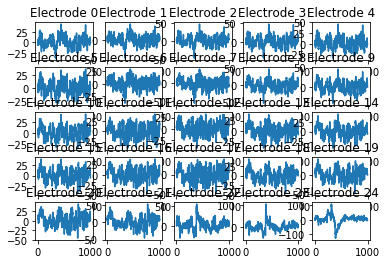

In [7]:
for i in range(image_shape[1]):
    plt.subplot(image_shape[1]**0.5,image_shape[1]**0.5,i+1)
    plt.plot(matfile['image'][0,i,:])
    plt.title("Electrode " + str(i))
    plt.rcParams["figure.figsize"] = [20,20]

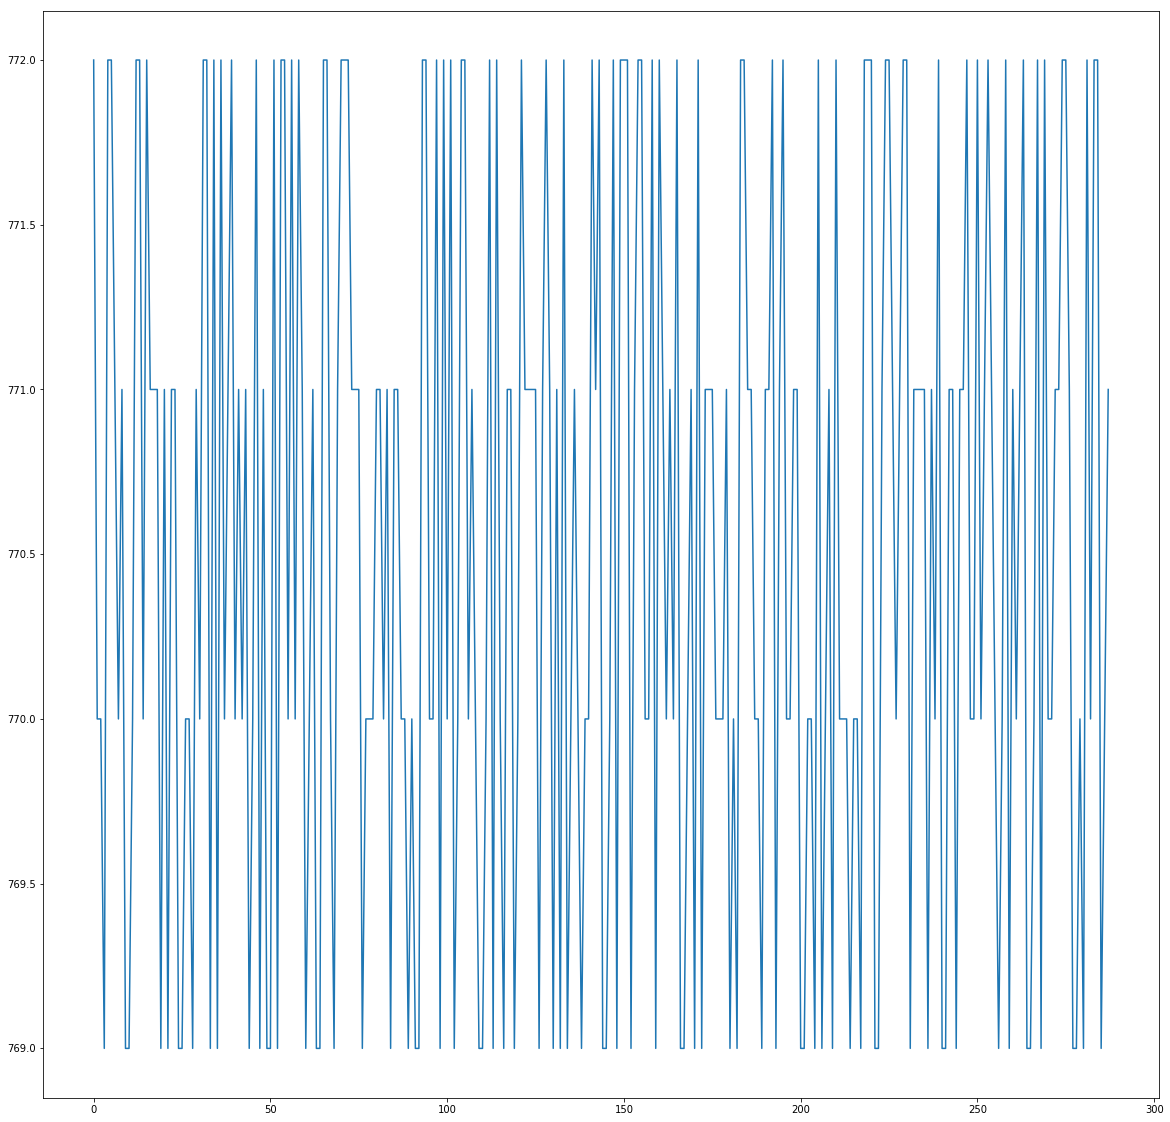

In [8]:
plt.plot(matfile['type'][0,:image_shape[0]])

In [9]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [10]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [11]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [12]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [13]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [14]:
print(training_data_Y[0].shape)

(200,)


In [15]:
from functools import reduce

def remove_nan_rows_A(A, b):
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
        
    assert A.shape[0] == b.shape[0]
    return A, b


cnn_trainval_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_X) #(2142, 22, 1000) 
cnn_training_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_X) #(1800, 22, 1000)
cnn_validation_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_X) #(342, 22, 1000)
cnn_test_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_X) #(450, 22, 1000)

cnn_trainval_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_Y) #(2142, )
cnn_training_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_Y) #(1800, )
cnn_validation_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_Y) #(342, )
cnn_test_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_Y) #(450,)


cnn_training_data_X, cnn_training_data_Y = remove_nan_rows_A(cnn_training_data_X, cnn_training_data_Y) #(1775,22,1000)
cnn_validation_data_X, cnn_validation_data_Y = remove_nan_rows_A(cnn_validation_data_X, cnn_validation_data_Y) #(340,22,1000)

cnn_test_data_X, cnn_test_data_Y = remove_nan_rows_A(cnn_test_data_X, cnn_test_data_Y) #(443,22,1000)

In [16]:
print cnn_training_data_X.shape
print cnn_validation_data_X.shape
print cnn_test_data_X.shape

(1775, 22, 1000)
(340, 22, 1000)
(443, 22, 1000)


In [17]:
# cnn_trainval_data_X = np.transpose(rnn_trainval_data_X, (0,2,1))
# mean_list = np.mean(cnn_trainval_data_X.reshape(-1, cnn_trainval_data_X.shape[-1]), axis=0)
# std_list = np.sqrt((np.var(cnn_trainval_data_X.reshape(-1, cnn_trainval_data_X.shape[-1]), axis=0)))
# cnn_training_data_X = (cnn_training_data_X - mean_list)/std_list
# cnn_validation_data_X = np.transpose(rnn_trainval_data_X, (0,2,1))

# print cnn_training_data_X.shape()
# print cnn_validation_data_X.shape()

In [18]:
import sklearn
from sklearn import svm

In [19]:
# svm_training_X = np.reshape(cnn_training_data_X, (1775, 22000))
# svm_training_Y = cnn_training_data_Y

In [20]:
# clf = svm.SVC()
# clf.fit(svm_training_X, svm_training_Y)

In [21]:
# svm_test_X = np.reshape(cnn_validation_data_X, (340, 22000))
# svm_test_Y = cnn_validation_data_Y
# predicted = clf.predict(svm_test_X)

# print(predicted)

In [22]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import gc
import resource
print(torch.__version__)

0.4.0a0+a2c3ffa


In [23]:
# helper function to get rss size, see stat(5) under statm. This is in pages...
def memory_usage():
    return int(open('/proc/self/statm').read().split()[1])


In [32]:
num_epochs = 20
batch_size = 15
learning_rate = 3e-4


#59% with this arch and 10 epochs - uping epochs
# 20 epochs - mem problem
#back to 10 epochs, changing first layer kernel from 15 to 25

# p = 20
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.BatchNorm1d(22),
#             nn.Conv1d(22, 22*p, kernel_size=25, groups=22),
#             nn.BatchNorm1d(22*p), 
#             nn.ELU(),
#             nn.AvgPool1d(kernel_size=75, stride=15))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(22*p, 30, kernel_size=3),
#             nn.BatchNorm1d(30),
#             nn.ELU())

#         self.fc4 = nn.Sequential(
#             nn.Linear(1770, 100), #100
#             nn.BatchNorm1d(100),
#             nn.ReLU())
        
#         self.fc5 = nn.Linear(100, 4)
#         self.output = nn.Softmax()
        
#     #basic forward - go through two conv layers + fc layer
   
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc4(out)
#         out = self.fc5(out)
#         out = self.output(out)
#         return out

from cnn.parametrized_cnn import CNN

cnn = CNN()

for i in cnn.parameters():
    print i.shape

torch.Size([22])
torch.Size([22])
torch.Size([44, 1, 25])
torch.Size([44])
torch.Size([44])
torch.Size([44])
torch.Size([30, 44, 3])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([100, 1770])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([4, 100])
torch.Size([4])


In [25]:
tensor_x_train = torch.Tensor(cnn_training_data_X)
tensor_y_train = torch.LongTensor(cnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(cnn_validation_data_X)
tensor_y_val = torch.LongTensor(cnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [26]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=True)

In [27]:
print len(train_loader)
#print len(val_loader)

119


In [33]:
import torch
# torch.manual_seed(1337)
cnn = CNN()

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(cnn.parameters(), lr=learning_rate, weight_decay=0.01)

train_acc = []
val_acc = []
loss_history = []
          
gc.collect()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        gc.collect()
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        labels = Variable(labels, volatile=True)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss)
        loss.backward()
        optimizer.step()
        del outputs
        del images, labels
        gc.collect()

        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(cnn_training_data_X.shape)//batch_size, loss.data[0]))
            gc.collect()
            max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            print("{:.2f} MB".format(max_mem_used /(1024*1024)))

        del loss
    
    gc.collect()
    cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    
    def test(X_data, Y_data, name='Train'):
        test_images = Variable(torch.Tensor(X_data), volatile=True)
        test_labels = torch.LongTensor(Y_data)
        
        test_outputs = cnn(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total = test_labels.size(0)
        test_correct = (test_predicted == test_labels).double().sum()
        test_acc = 100.0 * float(test_correct) / float(test_total)
        print('label set: %s predicted set: %s ----- %s Accuracy: %s %%' % (
               np.unique(test_labels.data), np.unique(test_predicted.data), name, test_acc))
        
        val_acc.append(test_acc)
        del test_outputs
        del test_images, test_labels
        gc.collect()
    
    test(cnn_training_data_X, cnn_training_data_Y, 'Train')
    test(cnn_validation_data_X, cnn_validation_data_Y, 'Val')
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [20/0] Loss: 1.3865
7.00 MB
Epoch [1/20], Iter [40/0] Loss: 1.3795
7.00 MB
Epoch [1/20], Iter [60/0] Loss: 1.3799
7.00 MB
Epoch [1/20], Iter [80/0] Loss: 1.3756
7.00 MB
Epoch [1/20], Iter [100/0] Loss: 1.3871
7.00 MB


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


label set: [0 1 2 3] predicted set: [0 1 2 3] ----- Train Accuracy: 41.8591549296 %
label set: [0 1 2 3] predicted set: [0 1 2 3] ----- Val Accuracy: 38.5294117647 %
Epoch [2/20], Iter [20/0] Loss: 1.3642
7.00 MB
Epoch [2/20], Iter [40/0] Loss: 1.3588
7.00 MB


KeyboardInterrupt: 

In [ ]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
images = Variable(torch.Tensor(cnn_test_data_X))
labels = torch.LongTensor(cnn_test_data_Y)
outputs = cnn(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * int(correct) / float(total)))

In [ ]:
#plot train/val accuracies
print train_acc
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
plt.plot(train_acc, color='red')
plt.plot(val_acc, color='blue')
plt.show()

In [ ]:
from guppy import hpy; h=hpy()

In [ ]:
h.heap()

In [ ]:
h.iso(1,[],{})